In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

In [2]:
df = pd.read_csv("../data/raw/heart_cleveland_upload.csv")

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [4]:
df.isna().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

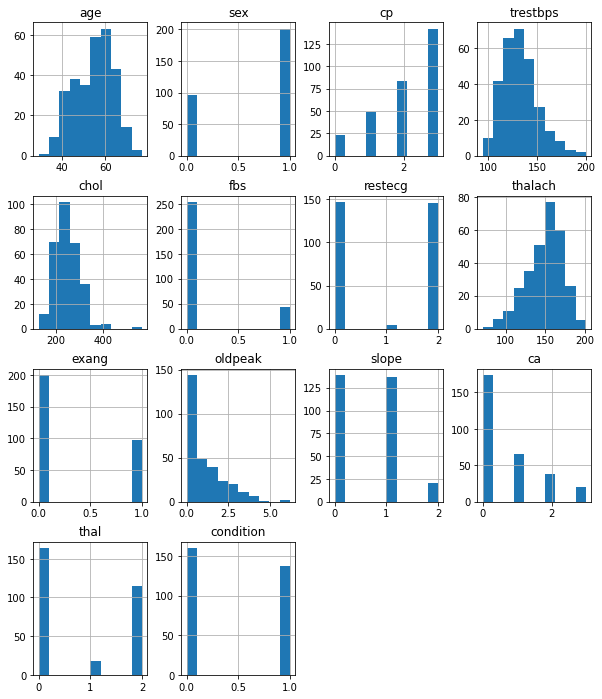

In [5]:
df.hist(figsize=(10, 12))
plt.show()

In [6]:
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
target = ["condition"]
numerical_features = list(set(df.columns).difference(categorical_features + target))

In [7]:
print("Numerical features description\n\n", df[numerical_features].describe())

Numerical features description

          trestbps        chol         age     thalach     oldpeak
count  297.000000  297.000000  297.000000  297.000000  297.000000
mean   131.693603  247.350168   54.542088  149.599327    1.055556
std     17.762806   51.997583    9.049736   22.941562    1.166123
min     94.000000  126.000000   29.000000   71.000000    0.000000
25%    120.000000  211.000000   48.000000  133.000000    0.000000
50%    130.000000  243.000000   56.000000  153.000000    0.800000
75%    140.000000  276.000000   61.000000  166.000000    1.600000
max    200.000000  564.000000   77.000000  202.000000    6.200000


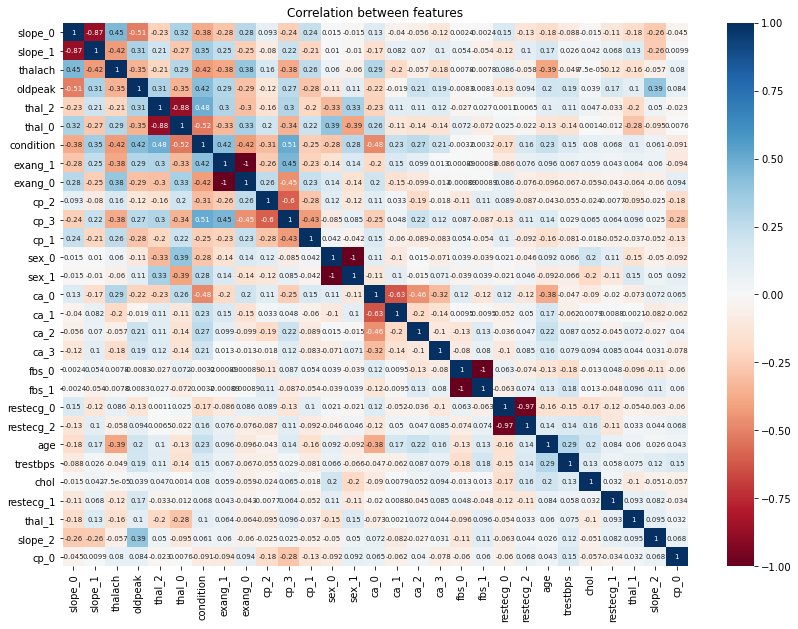

In [8]:
onehot_df = pd.get_dummies(df, columns=categorical_features)
plt.figure(figsize=(14, 10))

dissimilarity = 1 - abs(onehot_df.corr())
Z = linkage(dissimilarity, "complete")
labels = fcluster(Z, 0.8, criterion="distance")

plt.title("Correlation between features")
sns.heatmap(
    onehot_df.iloc[:, np.argsort(labels)].corr(),
    cmap="RdBu",
    annot=True,
    annot_kws={"size": 7},
)
plt.show()

From the matrix above, it's clear that the target variable is correlated with almost all features but 'fbs' and 'chol'.

In [9]:
one_hot_features = list(set(onehot_df.columns).difference(numerical_features + target))

# Prototyping.

In [10]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

TEST_SIZE = 0.2

RANDOM_SEED = 42
metrics = {"f1-score": f1_score, "accuracy": accuracy_score, "roc-auc": roc_auc_score}

In [11]:
X = onehot_df.drop(columns=target).reset_index(drop=True)
y = np.array(onehot_df[target], dtype=np.int8).reshape(-1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [13]:
transformer = ColumnTransformer(
    [("standard_scaler", StandardScaler(), numerical_features)], remainder="passthrough"
)
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [14]:
linear_model = LogisticRegression(max_iter=10000)
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

for name, func in metrics.items():
    print(f"{name}: {round(func(y_pred, y_test), 2)}")

f1-score: 0.79
accuracy: 0.8
roc-auc: 0.8


In [15]:
tree_model = RandomForestClassifier()

tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

for name, func in metrics.items():
    print(f"{name}: {round(func(y_pred, y_test), 2)}")

f1-score: 0.76
accuracy: 0.77
roc-auc: 0.77


In [16]:
XGB_METRIC = "logloss"

params = {
    "learning_rate": 2e-3,
    "objective": "binary:logistic",
    "n_estimators": 20,
    "eval_metric": "logloss",
    "num_class": 1,
    "use_label_encoder": False,
}


xgb_model = XGBClassifier(**params)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

for name, func in metrics.items():
    print(f"{name}: {round(func(y_pred, y_test), 2)}")

f1-score: 0.68
accuracy: 0.7
roc-auc: 0.7
